In [2]:
# download from https://buckeyecorpus.osu.edu/
import numpy as np

import zipfile
from torch.utils.data import Dataset

from IPython.display import clear_output

In [21]:
BUCKEYE2IPA = {
    'aa':'ɑ',
    'ae':'æ',
    'ay':'aɪ',
    'aw':'aʊ',
    'ao':'ɔ',
    'oy':'ɔɪ',
    'ow':'oʊ',
    'eh':'ɛ',
    'ey':'eɪ',
    'er':'ɝ',
    'ah':'ʌ',
    'uw':'u',
    'uh':'ʊ',
    'ih':'ɪ',
    'iy':'i',
    'm':'m',
    'n':'n',
    'en':'n̩',
    'ng':'ŋ',
    'l':'l',
    'el':'l̩',
    't':'t',
    'd':'d',
    'ch':'tʃ',
    'jh':'dʒ',
    'th':'θ',
    'dh':'ð',
    'sh':'ʃ',
    'zh':'ʒ',
    's':'s',
    'z':'z',
    'k':'k',
    'g':'ɡ',
    'p':'p',
    'b':'b',
    'f':'f',
    'v':'v',
    'w':'w',
    'hh':'h',
    'y':'j',
    'r':'ɹ',
    'dx':'ɾ',
    'nx':'ɾ̃',
    'tq':'ʔ',
    'er':'ɚ',
    'em':'m̩',
    # 'Vn':'◌̃',
}

In [53]:
SAMPLE_RATE = 16000
WAV_HEADER_SIZE = 44
SPLIT_CONVOS_AT_SILENCE_SECONDS = 2
MIN_SPEECH_SECONDS = 1
def get_utterances(speaker_zip, conversation):
    with zipfile.ZipFile(speaker_zip.open(conversation)) as utterance_zip:
        all_sections = []
        utterances = [x.split('.')[0] for x in utterance_zip.namelist() if not x.startswith('__') and x.endswith('.wav')]
        for utterance in utterances:
            with utterance_zip.open(f'{utterance}.wav') as wav_file:
                audio = np.frombuffer(wav_file.read(), dtype=np.int16)[WAV_HEADER_SIZE//2:]

            with utterance_zip.open(f'{utterance}.phones') as phn_file:
                start = 0
                timestamped_phonemes = []
                for line in phn_file.read().decode('utf-8').split('\n')[9:]:
                    if line == '':
                        continue
                    line = line.split(";")[0].strip()
                    fields = line.split()
                    stop = float(fields[0])
                    phone = BUCKEYE2IPA.get(fields[2], '') if len(fields) >= 3 else ''
                    timestamped_phonemes.append((phone, int(start * SAMPLE_RATE), int(stop * SAMPLE_RATE)))
                    start = stop
            
            # go through timestamped phonemes and identify silence and speech sections
            sections = []
            prev = 'nothing'
            sil_start, sil_end = 0, 0
            speech_start, speech_end = 0, 0
            speech_phones = []
            for phone, start, stop in timestamped_phonemes:
                if phone == '':
                    if prev != '':
                        sil_start = start
                    sil_end = stop
                significant_silence = False
                if prev == '' and phone != '':
                    silence = (sil_end - sil_start) / SAMPLE_RATE
                    if silence > SPLIT_CONVOS_AT_SILENCE_SECONDS:
                        significant_silence = True
                        speech = (speech_end - speech_start) / SAMPLE_RATE
                        # print('speech', speech)
                        # print('silence', silence)
                        if MIN_SPEECH_SECONDS < speech:
                            sections.append(("".join([x[0] for x in speech_phones]), audio[speech_start:speech_end], [(p, s - speech_start, e - speech_start) for p, s, e in speech_phones]))

                if phone != '':
                    if significant_silence:
                        speech_start = start
                        speech_phones = []
                    speech_end = stop
                    speech_phones.append((phone, start, stop))

                prev = phone

            all_sections.extend(sections)

        return all_sections

class BuckeyeDataset(Dataset):
    def __init__(self, split="s40", include_timestamps=False):
        self.datazip = zipfile.ZipFile('../.data/buckeye.zip', 'r')
        speakers = [x for x in self.datazip.namelist() if not x.startswith('__') and x.endswith('.zip')]
        speaker = f"buckeye/{split}.zip"
        assert speaker in speakers, f"Speaker {split} not found in {speakers}"
        self.speaker_zip = zipfile.ZipFile(self.datazip.open(speaker), 'r')
        self.conversations = self.speaker_zip.namelist()
        self.utterances_per_conversation = [len(get_utterances(self.speaker_zip, conversation)) for conversation in self.conversations]
        self.include_timestamps = include_timestamps

    def __del__(self):
        self.speaker_zip.close()
        self.datazip.close()

    def __len__(self):
        return sum(self.utterances_per_conversation)

    def _get_file(self, index):
        for conversation, utterances in zip(self.conversations, self.utterances_per_conversation):
            if index < utterances:
                break
            index -= utterances

        sections = get_utterances(self.speaker_zip, conversation)
        ipa, audio, timestamped_phonemes = sections[index]
        
        if self.include_timestamps:
            return ipa, audio, timestamped_phonemes
        else:
            return ipa, audio

    def __getitem__(self, index):
        if isinstance(index, int):
            return self._get_file(index)
        elif isinstance(index, slice):
            return [self._get_file(ix) for ix in range(*index.indices(len(self)))]
        else:
            return [self._get_file(ix) for ix in index]

In [54]:
speaker1 = BuckeyeDataset("s01")
print(len(speaker1))

91


('ʌmaɪmaɪvlʌvdɪnklʌbʌsmaɪɛntɛɹlaɪfθɚɾifoʊjɛɹsʌmboʊɹnɹeɪzdʌnnʌwɛssaɪʌfklʌmbɛsʌm', array([-29, -30, -23, ...,  69,  66,  40], dtype=int16))


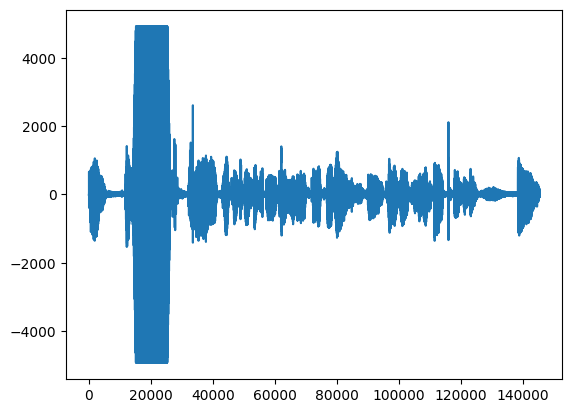

In [ ]:
import matplotlib.pyplot as plt
print(speaker1[0])
plt.plot(speaker1[0][1])
plt.show()

# Eval

In [46]:
import torch
from transformers import AutoProcessor, AutoModelForCTC
clear_output()

In [47]:
# set espeak library path for macOS
import sys
if sys.platform == "darwin":
    from phonemizer.backend.espeak.wrapper import EspeakWrapper

    _ESPEAK_LIBRARY = "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
    EspeakWrapper.set_library(_ESPEAK_LIBRARY)

In [68]:
# MODEL_ID = "KoelLabs/xlsr-timit-b0"
MODEL_ID = "KoelLabs/xlsr-timit-c0"
# MODEL_ID = "KoelLabs/xlsr-timit-d0"
# MODEL_ID = "KoelLabs/xlsr-timit-e0"
# MODEL_ID = "KoelLabs/xlsr-timit-b1"
# MODEL_ID = "KoelLabs/xlsr-timit-c1"
# MODEL_ID = "KoelLabs/xlsr-timit-d1"
# MODEL_ID = "KoelLabs/xlsr-timit-e1"
# MODEL_ID = "ginic/gender_split_70_female_4_wav2vec2-large-xlsr-53-buckeye-ipa"
# MODEL_ID = "mrrubino/wav2vec2-large-xlsr-53-l2-arctic-phoneme"
# MODEL_ID = "facebook/wav2vec2-lv-60-espeak-cv-ft"
# MODEL_ID = "speech31/XLS-R-300m-english-ipa"
# DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
DEVICE = 'cpu' # because I don't have enough memory on my mac
torch.mps.empty_cache()
processor = AutoProcessor.from_pretrained(MODEL_ID)
model = AutoModelForCTC.from_pretrained(MODEL_ID).to(DEVICE)

In [49]:
def transcribe_batch(batch):
    input_values = processor([x[1] for x in batch], sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True).input_values.type(torch.float32).to(DEVICE)
    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    return [processor.decode(ids) for ids in predicted_ids]

In [50]:
transcribe_batch([speaker1[0]])

['ʌmaɪmaɪvlɪvdʒiŋkləmbismaɪintaɪɹlaɪfθɹɾifɔɹjɪɹzʔɔmbɔɹɾiŋɹeizənðəwɛsaɪɾivklʌmbisʔʌm']

In [51]:
import panphon.distance

def cer(prediction, ground_truth):
    # Convert input lists to strings if they're lists
    if isinstance(prediction, list):
        prediction = "".join(prediction)
    if isinstance(ground_truth, list):
        ground_truth = "".join(ground_truth)

    # Handle empty strings
    if len(ground_truth) == 0:
        return 1.0 if len(prediction) > 0 else 0.0

    # Initialize the matrix
    matrix = np.zeros((len(prediction) + 1, len(ground_truth) + 1))

    # Fill first row and column
    for i in range(len(prediction) + 1):
        matrix[i, 0] = i
    for j in range(len(ground_truth) + 1):
        matrix[0, j] = j

    # Fill in the rest of the matrix
    for i in range(1, len(prediction) + 1):
        for j in range(1, len(ground_truth) + 1):
            if prediction[i - 1] == ground_truth[j - 1]:
                matrix[i, j] = matrix[i - 1, j - 1]
            else:
                substitution = matrix[i - 1, j - 1] + 1
                insertion = matrix[i, j - 1] + 1
                deletion = matrix[i - 1, j] + 1
                matrix[i, j] = min(substitution, insertion, deletion)

    # Calculate CER
    distance = matrix[len(prediction), len(ground_truth)]
    return distance / len(ground_truth)


def preprocess_ipa(ipa_string):
    """Preprocess an IPA string by removing unsupported symbols. Suggestions by David Mortensen, creator of panphon."""
    replacement_map = {
        "ɚ": "ɹ̩",  # Convert /ɚ/ to /ɹ/ (non-syllabic r)
        "ɝ": "ɹ",  # Convert /ɝ/ to /ɹ/ (non-syllabic r)
        "ː": "",  # Remove length mark (or duplicate previous vowel if length is important)
        "͡": "",  # Remove tie bar (or split into components if part of an affricate)
        "g": "ɡ",  # replace two versions of g, TIMIT uses ascii g and STANDARD IPA uses unicode g
    }
    processed_string = "".join(replacement_map.get(char, char) for char in ipa_string)

    return processed_string


def panphon_model_eval(label, predicted):
    label_sequence = preprocess_ipa(label)
    pred_sequence = preprocess_ipa(predicted)

    weighted_feature_dist = panphon.distance.Distance().weighted_feature_edit_distance(
        label_sequence, pred_sequence
    )
    cer_score = cer(predicted, label)

    return cer_score, weighted_feature_dist

In [69]:
# BATCH_SIZE = 4
BATCH_SIZE = 1 
average_cer = 0
average_feature_distance = 0
amount = len(speaker1)
for i in range(0, amount, BATCH_SIZE):
    torch.mps.empty_cache()
    size = min(BATCH_SIZE, amount - i)
    transcriptions = transcribe_batch(speaker1[i:i+size])
    for j in range(size):
        cer_score, feature_distance = panphon_model_eval(speaker1[i+j][0], transcriptions[j])
        average_cer += cer_score
        average_feature_distance += feature_distance

print(f"Average CER: {average_cer / amount}")
print(f"Average feature distance: {average_feature_distance / amount}")

Average CER: 0.36325151904815167
Average feature distance: 157.21085164835165


SPEAKER 1:
B0 CER: 0.33509908901476476
B0 WFED: 154.88942307692307

B1 CER: 0.3526904191725863
B1 WFED: 161.6414835164835

C0 CER: 0.36325151904815167
C0 WFED: 157.21085164835165

Ginic CER: 0.2503032326953035
Ginic WFED: 123.88461538461539

Facebook 60 CER: 1.3267747708912827
Facebook 60 WFED: 151.83035714285714

Arctic Finetune CER: 0.7028620455056792
Arctic Finetune WFED: 177.6195054945055

Speech 31 CER: 1.3429352203450171
Speech 31 WFED: 218.2129120879121